In [1]:
!make -C .. calibrate_ucm

make: Entering directory '/home/martibosch/data-science/lausanne-heat-islands'
make: Nothing to be done for 'calibrate_ucm'.
make: Leaving directory '/home/martibosch/data-science/lausanne-heat-islands'


In [2]:
import json
import tempfile

import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from sklearn import metrics

from lausanne_heat_islands import utils
from lausanne_heat_islands.invest import utils as invest_utils

In [3]:
calibrated_params_filepath = '../data/interim/invest/calibrated-params.json'
agglom_lulc_filepath = '../data/raw/agglom-lulc.tif'
biophysical_table_filepath = '../data/interim/biophysical-table-shade.csv'
ref_et_filepath = '../data/interim/invest/ref-et.nc'
station_locations_filepath = '../data/raw/stations/station-locations.csv'
station_tair_filepath = '../data/interim/station-tair.csv'

In [4]:
with open(calibrated_params_filepath) as src:
    model_params = json.load(src)

In [5]:
station_location_df = pd.read_csv(station_locations_filepath, index_col=0)

In [6]:
ucm_wrapper = invest_utils.UCMWrapper(agglom_lulc_filepath,
                                      biophysical_table_filepath,
                                      ref_et_filepath, station_tair_filepath,
                                      station_locations_filepath, model_params)

In [7]:
comparison_df = ucm_wrapper.get_sample_comparison_df().dropna()
comparison_df['elev'] = comparison_df['station'].apply(
    lambda stn: station_location_df.loc[stn, 'alt'])

In [8]:
model_perf_df = ucm_wrapper.get_model_perf_df().rename(
    index={
        'uniform': 'Uniform',
        'normal': 'Normal',
        'invest_ucm': 'InVEST UCM'
    })
model_perf_df.style.set_caption('Table 1. Model performance')

,R^2,MAE,RMSE
Uniform,0.568815,1.947758,2.415257
Normal,0.577332,1.885107,2.391284
InVEST UCM,0.903303,0.954508,1.143770


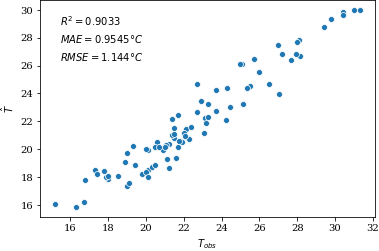

In [9]:
fig = utils.plot_pred_obs(comparison_df)
fig.savefig('../reports/figures/invest-ucm-pred-obs.pdf')

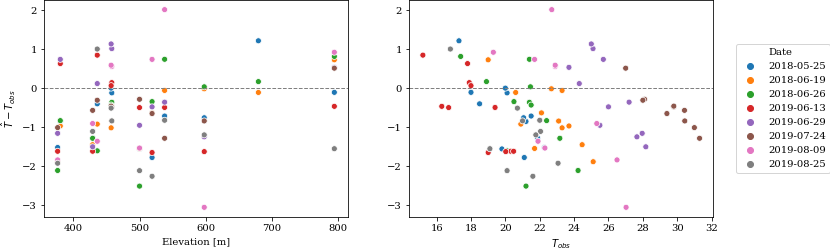

In [10]:
fig = utils.plot_err_elev_obs(comparison_df)
fig.savefig('../reports/figures/invest-ucm-errors.pdf')

### Plotting the maps simulated by the calibrated urban cooling model

In [11]:
!make -C .. tair_ucm_maps

make: Entering directory '/home/martibosch/data-science/lausanne-heat-islands'
make: Nothing to be done for 'tair_ucm_maps'.
make: Leaving directory '/home/martibosch/data-science/lausanne-heat-islands'


In [12]:
tair_ucm_filepath = '../data/processed/tair-ucm-maps.nc'

In [13]:
T_ucm_da = xr.open_dataarray(tair_ucm_filepath)

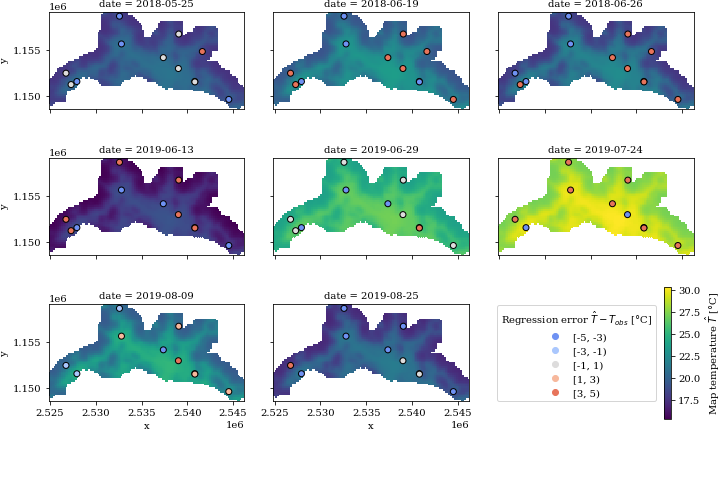

In [14]:
g = utils.plot_T_maps(T_ucm_da,
                           station_location_df,
                           comparison_df=comparison_df)
g.fig.savefig('../reports/figures/invest-ucm-maps.png')